In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import util
import seaborn as sns
from glob import glob

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../src/')
from Global_trajectory_analysis import LinearRegression_area_vs_time
from trajectory_viz import plot_traj

### Physical units

In [2]:
dx=11 # mkm
dt=10 # min

## Read data

In [3]:
INPUT="../data"
FileName="../data/supplementaryMovie5_ancestor_ALI_Traj_data_cleaned_3px_min_area.csv"
Traj=pd.read_csv(FileName)
Traj.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'],inplace=True)
TrajGroup=Traj.groupby('traj_id')
print("Total number points {:}".format(Traj.shape))
print("Number Trajectories {:}".format(TrajGroup.ngroups))

Total number points (83654, 15)
Number Trajectories 4811


In [4]:
Traj.columns

Index(['traj_id', 'point_id', 'frame', 'r', 'c', 'dist', 'minr', 'minc',
       'maxr', 'maxc', 'area', 'major_axis', 'minor_axis', 'perimeter',
       'eccentricity'],
      dtype='object')

## Select only long trajectories

In [5]:
TrajLong=TrajGroup.filter(lambda x:len(x['frame'])>25)
TrajLongGroup=TrajLong.groupby('traj_id')

In [6]:
TrajMeanArea=TrajLong.groupby('traj_id').apply(lambda x: np.mean(x['area']))

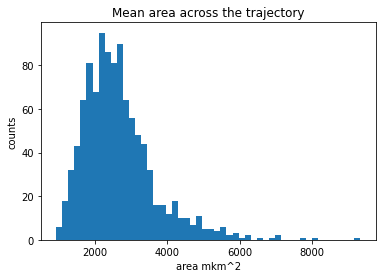

In [7]:
plt.hist(TrajMeanArea*dx*dx,bins=50);
plt.title("Mean area across the trajectory")
plt.xlabel("area mkm^2")
plt.ylabel("counts")
plt.savefig("../results/for presentation/Mean area across the trajectory"+".png",bbox_inches='tight')

In [8]:
Area=TrajMeanArea*dx*dx

In [9]:
Area.describe()

count    1043.000000
mean     2670.594932
std      1008.498186
min       932.148148
25%      1977.884615
50%      2499.115385
75%      3111.785613
max      9330.444444
dtype: float64

## Linear regression fit area vs time

In [10]:
def LinearRegression_area_vs_time(OneTraj,dx,dt):
    
    """
    fit linear regression to the area vs time for selected trajectory
    input: one trajectory coordinats, 
            dx px in physical units 
            dt in physical units
    output: 
    """
    trajID=OneTraj["traj_id"].values[0]
    len_traj=OneTraj['frame'].size
    # start from time=0, it is required for fitting
    frames=(OneTraj['frame'].values-OneTraj['frame'].min())*dt 
    Time=frames.reshape((-1, 1))
    Area=OneTraj['area'].values*dx*dx
    std_area=np.std(Area)

    model=LinearRegression()
    model.fit(Time, Area)
    area_predict=model.predict(Time)
    rmse=np.sqrt(mean_squared_error(Area,area_predict))
    
    FitResult=pd.Series([trajID,model.coef_[0],model.intercept_,model.score(Time, Area),rmse,np.median(Area),std_area,len_traj],
                        index=["traj_id","slope","intersept","R2","rmse","med_area","std_area","len_traj"])
    #print(model.score(Time, Area),model.coef_[0],model.intercept_)
    #plt.plot(Time,Area,color="blue")
    #plt.plot(Time,model.predict(Time),color="red")
    
    return FitResult

In [11]:
RegFitArea=TrajLongGroup.apply(LinearRegression_area_vs_time,dx,dt)
RegFitArea.head(5)

traj_id      slope    intersept        R2         rmse  med_area  \
traj_id                                                                     
4.0          4.0   9.866154  3071.538462  0.588464   618.804057    3993.0   
20.0        20.0  12.949512  3927.378307  0.706806   649.613975    5687.0   
21.0        21.0   1.824308  2503.769231  0.009018  1434.265553    2238.5   
22.0        22.0  -1.218864  2264.748677  0.039904   465.669623    2178.0   
24.0        24.0   4.232784  1139.256614  0.473907   347.364932    1694.0   

            std_area  len_traj  
traj_id                         
4.0       964.604344      26.0  
20.0     1199.715276      27.0  
21.0     1440.776954      26.0  
22.0      475.248381      27.0  
24.0      478.910830      27.0

In [18]:
Sample_df=RegFitArea.sample(n=14)
SelectedId=Sample_df["traj_id"]
sns.set(font_scale=0.9)

fig,ax=plt.subplots(nrows=2,ncols=7,figsize=(15,8))
counter=0
for id,axplot in zip(SelectedId,ax.ravel()):
    Traj=TrajGroup.get_group(id)
    #plot_traj(Traj,axplot)
    start=Traj.frame.iloc[0]
    axplot.plot((Traj.frame-start)*dt,Traj.area*dx*dx)
    max_frame=Traj.frame.max()-start
    axplot.plot([0,max_frame*dt],[RegFitArea.loc[id].intersept,RegFitArea.loc[id].intersept+RegFitArea.loc[id].slope*Traj.frame.max()],
                label="slope={:.2f} \n R2={:.2f} \n rmse={:.2f}".format(RegFitArea.loc[id].slope,RegFitArea.loc[id].R2,RegFitArea.loc[id].rmse))
    counter=counter+1
    axplot.legend()
fig.savefig("../results/for presentation/Sample_fit"+".png",bbox_inches='tight')

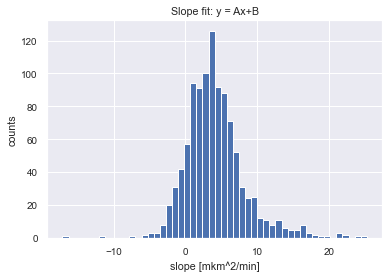

In [13]:
RegFitArea.slope.hist(bins=50)
plt.title("Slope fit: y = Ax+B")
plt.xlabel("slope [mkm^2/min]")
plt.ylabel("counts")
plt.savefig("../results/for presentation/Slope_fit"+".png",bbox_inches='tight')

In [14]:
20*11*11

2420

In [18]:
RegFitArea.columns

Index(['traj_id', 'slope', 'intersept', 'R2', 'rmse', 'med_area', 'std_area',
       'len_traj'],
      dtype='object')

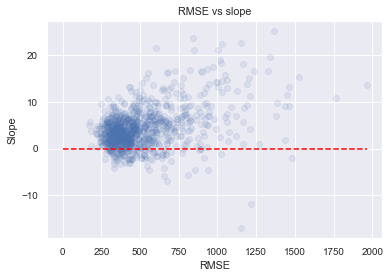

In [39]:
plt.scatter(RegFitArea.rmse,RegFitArea.slope,alpha=0.1)
plt.title("RMSE vs slope")
plt.xlabel("RMSE")
plt.ylabel("Slope")
plt.hlines(y=0,xmin=0,xmax=RegFitArea.rmse.max(),linestyle='--',color='red')
plt.savefig("../results/for presentation/Slope_RMSE"+".png",bbox_inches='tight')

In [11]:
RegFitArea[RegFitArea.len_traj>25].slope.hist(bins=100)

In [12]:
RegFitArea[RegFitArea.len_traj>25].slope.describe()

count    1043.000000
mean        4.164099
std         4.223214
min       -17.108425
25%         1.514347
50%         3.715690
75%         5.955446
max        25.241575
Name: slope, dtype: float64

In [20]:
Sample_df=RegFitArea[RegFitArea.len_traj>25].sample(n=14)
SelectedId=Sample_df["traj_id"]
sns.set(font_scale=0.9)

fig,ax=plt.subplots(nrows=2,ncols=7,figsize=(20,8))
counter=0
for id,axplot in zip(SelectedId,ax.ravel()):
    Traj=TrajGroup.get_group(id)
    #plot_traj(Traj,axplot)
    start=Traj.frame.iloc[0]
    axplot.plot((Traj.frame-start)*dt,Traj.area*dx*dx)
    max_frame=Traj.frame.max()
    axplot.plot([0,max_frame*dt],[RegFitArea.loc[id].intersept,RegFitArea.loc[id].intersept+RegFitArea.loc[id].slope*Traj.frame.max()],
                label="slope={:.2f} \n R2={:.2f} \n rmse={:.2f}".format(RegFitArea.loc[id].slope,RegFitArea.loc[id].R2,RegFitArea.loc[id].rmse))
    counter=counter+1
    axplot.legend()
plt.savefig("../results/for presentation/Sample_area_fit"+".png",bbox_inches='tight')

In [35]:
RegFitArea.describe()

traj_id        slope     intersept           R2     std_area  \
count   4811.000000  4811.000000   4811.000000  4811.000000  4811.000000   
mean    3761.144253     4.753652   1758.164170     0.277057   605.010670   
std     2696.161980    12.592863   1343.255616     0.230146   420.172997   
min        1.000000  -210.885714   -795.911111     0.000000    45.094038   
25%     1468.500000     0.778370    769.657509     0.067290   335.182436   
50%     3224.000000     3.723077   1320.658120     0.232049   467.735174   
75%     5694.000000     6.994866   2381.661172     0.447122   732.707404   
max    10109.000000   135.865714  10348.380952     0.928679  4338.974444   

          len_traj  
count  4811.000000  
mean     17.388069  
std       7.389272  
min       6.000000  
25%      10.000000  
50%      18.000000  
75%      25.000000  
max      27.000000

In [9]:
sns.set(font_scale=2)
RegFitArea[["slope","intersept","R2","std_area","len_traj"]].hist(bins=100,layout=(1,5),figsize=(28,7));

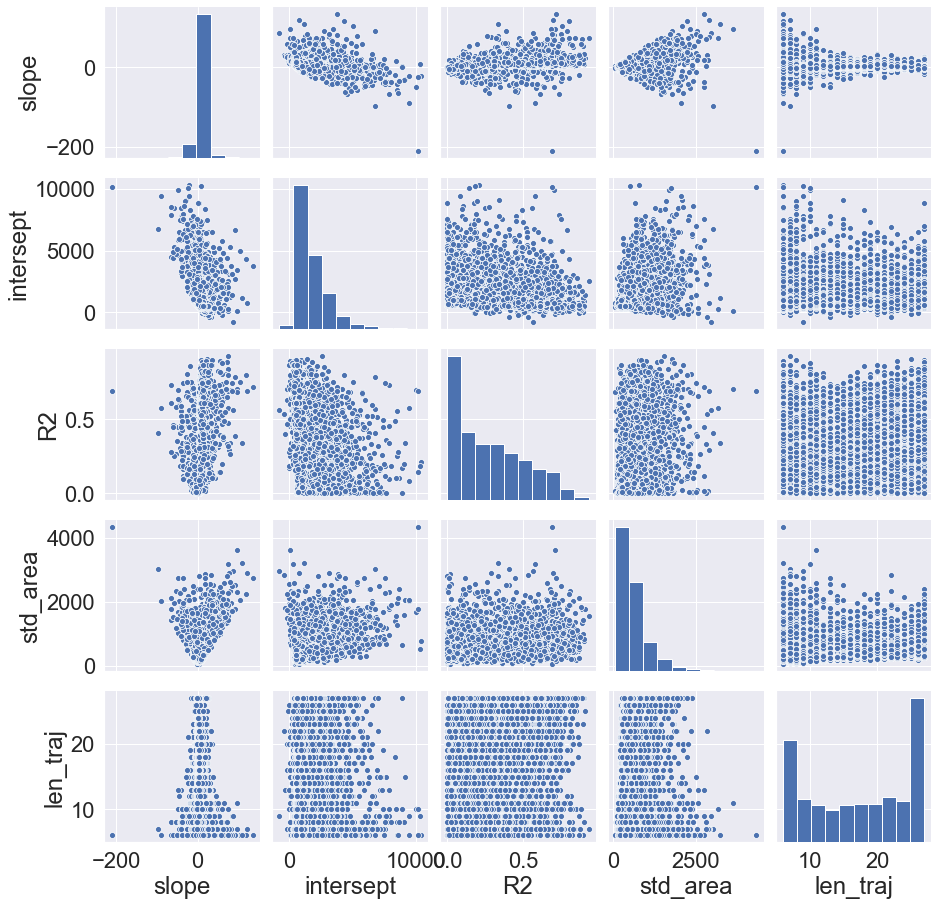

In [10]:
sns.pairplot(RegFitArea[["slope","intersept","R2","std_area","len_traj"]])

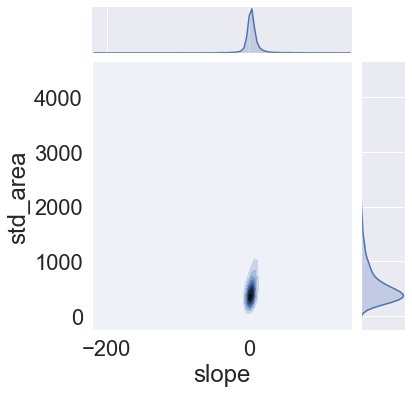

In [12]:
plot=sns.jointplot(x=RegFitArea["slope"],y=RegFitArea["R2"],kind='kde')
#plot.ax_marg_x.set_xlim(-5,5)

plot=sns.jointplot(x=RegFitArea["slope"],y=RegFitArea["std_area"],kind='kde')
#plot.ax_marg_x.set_xlim(-5,5)
#plot.ax_marg_y.set_ylim(0,15)